# Лекция 13: Dask Delayed

__Автор: Сергей Вячеславович Макрушин__ e-mail: SVMakrushin@fa.ru 

Финансовый универсиет, 2020 г. 

При подготовке лекции использованы материалы:
* ...

V 0.3 02.12.2020

## Разделы: <a class="anchor" id="разделы"></a>
* [Серии (Series) - одномерные массивы в Pandas](#серии)
* [Датафрэйм (DataFrame) - двумерные массивы в Pandas](#датафрэйм)
    * [Введение](#датафрэйм-введение)
    * [Индексация](#датафрэйм-индексация)    
* [Обработка данных в библиотеке Pandas](#обработка-данных)
    * [Универсальные функции и выравнивание](#обработка-данных-универсальные)
    * [Работа с пустыми значениями](#обработка-данных-пустрые-значения)
    * [Агрегирование и группировка](#обработка-данных-агрегирование)    
* [Обработка нескольких наборов данных](#обработка-нескольких)
    * [Объединение наборов данных](#обработка-нескольких-объединение)
    * [GroupBy: разбиение, применение, объединение](#обработка-нескольких-групбай)
 
-

* [к оглавлению](#разделы)

In [1]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

## Распараллеливание кода с помощью `dask.delayed`

При помощи `dask.delayed` можно распараллелить произвольный алгоритм, написанный на Python. 
* `dask.delayed` имеет смысл применять, если работа алгоритма плохо ложится на логику, предлагаемую `dask.Bag`, `dask.Array` или `dask.DataFrame`. 
* `dask.delayed` позволяет быстро превратить существующий алгоритм, имеющий потенциал расспаралеливания, в параллельный. Для этого очень удобно использовать аннотации `@delayed`.
* Использование `dask.delayed` позволяет генерировать граф зависимостей задач, который будет исполнятся параллельно с помощью планировщика Dask. 
* Паралельную обработку данных с помощью `dask.delayed` можно сочетать с испоьзованием `dask.Bag`, `dask.Array` или `dask.DataFrame` за счет применения функций `from_delayed` `to_delayed`.

### Вводный пример

In [37]:
from time import sleep

def inc(x):
    sleep(1) # имитриуем длительные вычисления
    return x + 1

def add(x, y):
    sleep(1) # имитриуем длительные вычисления
    return x + y

In [8]:
%%time
# Последовательное выполнение трех операций займет 3 секунды:

x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3.01 s


Потенциал распараллеливания существующей реализации алгоритма: два вызова `inc` могут быть выполнены параллельно, т.к. они полностью независимы друг от друга.

* С помощью `dask.delayed` мы сгенерируем граф зависимостей задач, который будет исполнятся параллельно с помощью планировщика Dask.
* Для этого каждую функцию мы декарируем с помощью `dask.delayed` - по сути создаем обертку (wrapper) для нее.
    * Вызов функции, декорированной с помощью `dask.delayed`, будет выглядеть как и раньше - ей будут передаваться параметры, но сама функция не будет вызываться, вместо этого вызов функции будет возращать отложенный объект (delayed object) - объект типа `Delayed`.
    * Этот объект является посредником (proxy) который хранит информацию о том, какая функция и к каким аргументам должна быть применена чтобы получить результат вызова. Полученное множество отложенных объектов связанных зависимостями по данным по сути формирует граф зависимостей задач.
* Справка: *Декоратор - это функция, которая принимает функцию или метод в качестве аргумента и возвращает новую функцию или метод, включающую декорированную функцию или метод, с дополнительными функциональными возможностями.* 

In [2]:
import dask
from dask import delayed

In [38]:
%%time
# Ячейка выполнится почти моментально, т.к. функции рассчетов вызываться не будут, а будет строится граф зависимостей задач.

x = delayed(inc)(1) # декорирование функции inc и вызов декорированной функции с аргументом 1
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 0 ns


In [39]:
z # переменная хранит отложенный объект

Delayed('add-f9f153f5-e65e-42cb-a657-fbf8d00d9801')

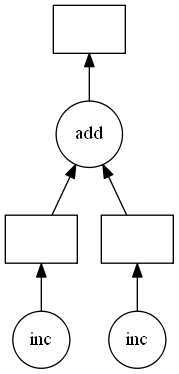

In [134]:
# визуализация построенного графа зависимости задач:
z.visualize()

<em class="df"></em> __Ленивые вычисления__ (англ. lazy evaluation, также отложенные вычисления) — применяемая в некоторых языках программирования стратегия вычисления, согласно которой вычисления следует откладывать до тех пор, пока не понадобится их результат. 

* При использовании ленивых вычислений программист просто __описывает зависимости функций друг от друга__.
* Фактические вычисления __происходят "по требованию"__ и естественным образом определяют необходимые для выполенения промежуточные вычисления.
* Отложенные вычисления естественным образом __ложатся на функциональную парадигму программирования__.

Отложенные вычисления позволяют сократить общий объём вычислений за счёт: 
* избежания __вычислений__ (промежуточных значений), __результаты которых не будут востребованы__;
* избежания __повторного выполнения одинаковых вычсилений__ (промежуточных значений) за счет их совместного использования (share);
* уменьшения объема используемой памяти за счет того, что __промежуточные значения создаются только тогда, когда они востребованы__.

In [40]:
%%time
# Запуск вычислений по построенному графу зависимостей задач:

z.compute()

Wall time: 2.02 s


5

* При работе с `dask.Bag`, `dask.Array` или `dask.DataFrame` паралелизм заложен в функциях, реализованных для этих структур данных, и мы пользуемся готовым решением. Это высокуровневый подход к распараллеливанию.
* Использование `dask.delayed` позволяет формировать граф зависимостей задач в соответствии со структурой вызывов имеющегося алгоритма. Это более низкоуровневый подход к распараллеливанию. Его специфика:
    * <em class="pl"></em> Не нужно адаптировать алгоритм под `dask.Bag`, `dask.Array` или `dask.DataFrame`.
    * <em class="pl"></em> Можно реализовать потенциал распараллеливания, плохо ложащегося на работу с `dask.Bag`, `dask.Array` или `dask.DataFrame`
    * <em class="mn"></em> Нужно самостоятельно распаралелить реализацию алгоритма

Распараллеливание алгоритмов сложная задача не имеющая универсального решения. Существует нексколько стратегий, которые успешно применяются во многих конкретных задачах. 

Для эффективного использования `dask.delayed` для распараллеливания вычислений существует важное техническое требование: каждый вызов `compute()` должен делатся для большого объема вычислений после их оформления в виде большого количества вызовов `dask.delayed`. После того как будет создан обширный граф зависимостей задач метод `compute()` запускает планировщик, который сможет праллельно задействовать доступные вычислительные ресурсы.

При необходимости допустимо запускать `compute()` в середине процесса вычислений (например, когда без расчета конкретных результатов невозможно определить дальнейший ход вычислений), но нужно иметь ввиду, что для выполнения следующих шагов нужно будет ожидать, пока запущенные `compute()` вычисления не вернут результат.

In [42]:
def f(a):
    print(f'computation f({a}):', end='')
    for _ in range(10):
        sleep(0.2)
        print(f'{a}.', end='')
    return a + 1

l = list(range(4))

In [43]:
%%time

# НЕ верная организация расчетов:
for x in l:
    y = delayed(f)(x)
    y.compute()  # вызов compute() после создания каждого объекта Delayed не приведет к распараллеливанию вычислений

computation f(0):0.0.0.0.0.0.0.0.0.0.computation f(1):1.1.1.1.1.1.1.1.1.1.computation f(2):2.2.2.2.2.2.2.2.2.2.computation f(3):3.3.3.3.3.3.3.3.3.3.Wall time: 8.21 s


In [44]:
%%time

# правильная организация расчетов:
results = []
for x in l:
    y = dask.delayed(f)(x)
    results.append(y)

results = dask.compute(*results)  # вызов compute() после формирования большого количества объектов Delayed 

computation f(1):computation f(0):computation f(3):computation f(2):3.0.1.2.2.3.1.0.0.1.3.2.3.2.1.0.1.3.2.0.2.3.0.1.3.2.0.1.0.1.2.3.1.0.3.2.0.3.1.2.Wall time: 2.06 s


### Использование декораторов

Декоратор - это функция, которая принимает функцию или метод в качестве аргумента и возвращает новую функцию или метод, включающую декорированную функцию или метод, с дополнительными функциональными возможностями.

В Python есть специальный синтаксис для декорирования функций во время их определения.

В большинстве случаев более удобным способом использования `dask.delayed` является его применение в виде декоратора `@delayed`. Но, нужно иметь в виду, что этот способ не подходит для функций, описанных во внешних библиотеках

In [47]:
@delayed
def inc(x):
    sleep(1) # имитриуем длительные вычисления
    return x + 1

@delayed
def add(x, y):
    sleep(1) # имитриуем длительные вычисления
    return x + y

In [48]:
# после объявления функций с декоратором @delayed вызов декорированных функций выглядит стандартным:

x1 = inc(1) 
y1 = inc(2)
z1 = add(x1, y1)

x2 = inc(2) 
y2 = inc(3)
z2 = add(x2, y2)

z3 = add(z1, z2)

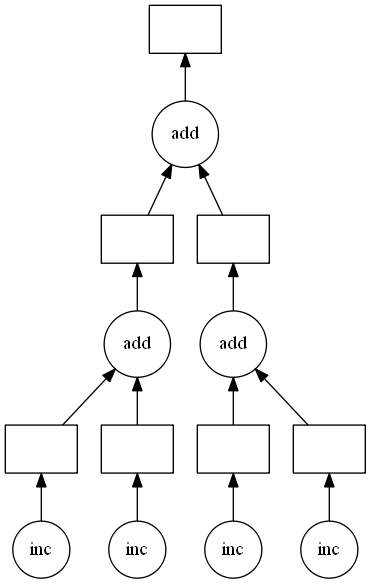

In [142]:
z3.visualize()

In [49]:
%%time

z3.compute()

Wall time: 3.03 s


12

In [50]:
# функция из внешней библиотеки:
from operator import sub

sub(10, 1)

9

In [51]:
# декорирование функции из внешней библиотеки:
sub = delayed(sub)

sub

Delayed('sub-1c72edb7-c906-4f0c-a600-e92ba3d6facb')

In [52]:
# использование декорированной функции выглядит стандартно:
s = sub(10, 1)

# результат применения функции теперь - отложенный объект:
s

Delayed('sub-68564163-4d5d-4542-9362-7b93e06d61d1')

In [53]:
s.compute()

9

Декорировать нужно функцию а не результат ее вызова!

In [54]:
def f(a, b):
    print(f'computation f({a}, {b})')
    return a + b

In [55]:
# НЕ верно:
fd1 = delayed(f(10,1)) # декорируется РЕЗУЛЬТАТ вычисления функции f
fd1.visualize()

computation f(10, 1)


RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.

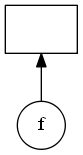

In [150]:
# верно:
fd2 = delayed(f)(10,1) # декорируется функция f
fd2.visualize()

In [56]:
fd2.compute()

NameError: name 'fd2' is not defined

## Совместное использование повторяющихся вычислений

Отложенные вычисления позволяют сократить общий объём вычислений за счёт: 
* ...
* *избежания повторного выполнения одинаковых вычсилений (промежуточных значений) за счет их совместного использования (share);*
* ...

Для достижения этого результата отложенные вычисления часто совмещаются с мемоизацией. 

<em class="df"></em> __Мемоизация__ (memoization) — сохранение результатов выполнения функций для предотвращения повторных вычислений. Это один из способов оптимизации скорости выполнения программ. Перед вызовом функции проверяется, вызывалась ли функция ранее с такими параметрами:
* если не вызывалась, функция вызывается и результат её выполнения сохраняется в таблице поиска (словаре), в которой ключами являются параметры функции, а значениями - значения функции для этих параметров;
* если вызывалась, используется сохранённый в таблице поиска результат.

Для использования мемоизации функции должны быть чистыми (pure functions), т.е.:
* детерминированными - вызов функции для одних и тех же значений параметров должен возвращать одинаковый результат;
* без побочных эффектов - т.е. без изменения контекста: 
    * модификации значения глобальных переменных, 
    * выполнения операций ввода-вывода, 
    * модификации переданных в функцию параметров

In [59]:
# НЕжелательно (для использование в мемоизации) - с побочным эффектом: 
def f(x):
    x.append(1)  # модификации переданных в функцию параметров
    return x

In [60]:
l1 = list('abc')
print(l1)
l2 = f(l1)#.compute()
print(l1, l2)

['a', 'b', 'c']
['a', 'b', 'c', 1] ['a', 'b', 'c', 1]


In [61]:
# предпочтительно (для использование в мемоизации) - без побочных эффектов:
def f(x):
    return x + [1] # значение x не меняется (создается новый список)

In [62]:
l1 = list('abc')
print(l1)
l2 = f(l1)
print(l1, l2)

['a', 'b', 'c']
['a', 'b', 'c'] ['a', 'b', 'c', 1]


In [63]:
# НЕжелательно: 
@delayed
def f(x):
    x.append(1)  # модификации переданных в функцию параметров
    return x

In [64]:
# предпочтительно:
@delayed
def f(x):
    return x + [1] # значение x не меняется (создается новый список)

In [65]:
@delayed
def f(x):
    x = copy(x) # способ избежать изменения параметра при использовании операции изменяющей значение
    x.append(1)
    return x

----

Нежелательно применять функции, использующие глобальное состояние. Такие функции могут корректно работать только при использовании диспетчера Dask, основанного на потоках (`threaded`), при работе с диспетчером `multiprocessing` или `distributed` использование таких функций может привести к сбивающим с толку ошибкам.

In [66]:
l = []

@delayed
def f(x):
    l.append(x) # изменение глобального состояния

---

НЕ полагайтесь на побочные эффекты функций, т.к. при использовании `dask.delayed` функции создадут эти эффекты только на этапе выполнения графа зависимости задач (например, после вызова `compute`).

* ```python
dask.delayed(f)(1, 2, 3)  # побочный эффект не будет наблюдаться```
* ```python
x = dask.delayed(f)(1, 2, 3)
...
dask.compute(x, ...)  # только во время выполнения всего графа зависимостей задач будет наблюдаться эффект
```

---

Декоратор `dask.delayed` кроме оборачиваемого объекта может принимать необязательные параметры. В том числе имеется необязательный параметр:

`pure:bool`, optional - указывает является ли возвращаемыей объект отложенных вычислений чистой функцией. Если значение параметра `True` для вызовов будет создаваться поисковая таблица для оптимизации за счет совместного использования резульатов идентичных обращений к функции. Если значение параметра не передано, то значение по умолчанию будет соотвенствовать глобальному параметру `delayed_pure` или `False`, в случае, если этот параметр не установлен.

In [68]:
# указываем, что функция является чистой:
@delayed(pure=True)
def inc_p(x):
    sleep(1) # имитриуем длительные вычисления
    return x + 1

@delayed
def add(x, y):
    sleep(1) # имитриуем длительные вычисления
    return x + y

In [69]:
x1_p = inc_p(1) 
y1_p = inc_p(2)
z1_p = add(x1_p, y1_p)

x2_p = inc_p(2) 
y2_p = inc_p(3)
z2_p = add(x2_p, y2_p)

z3_p = add(z1_p, z2_p)

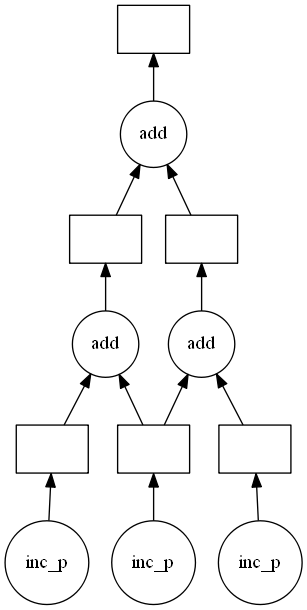

In [161]:
z3_p.visualize()

__Оптимизация__ за счет совместного использования резульатов идентичных обращений к функции __произведена еще на стадии построения графа зависимости задач__!

## Использование `dask.delayed` для объектов

При помощи функции `dask.delayed` можно создавать не только обертки для функций, но и обертки для объектов Python. Такие объекты используются для явного создания прокси объектов типа Delayed. 

Явное использование `dask.delayed` для объектов оправдано при многократной передаче больших объектов на вход в отложенные функции. Это нужно т.к. каждый раз, когда на вход в отложенную функцию передается конкретный объект (не обернутый в `dask.delayed`), Dask выполняет хэшировние этого объекта для его именования. Это действие производится быстро (со скоростью примерно 500 Мб/с), но при многократном повтороении может существенно увеличить скорость построения графа зависимостей задач. 

Выполнение этой операции может быть особенно важно при использовании распределененного кластера - это позволит избежать многократной пересылки данных при каждом вызове отложенной функции.

In [70]:
%%time
# Это рассчет времени выполнения построения графа потока вычисления, а не рассчетов!

x = list(range(100000)) # большой список

def add_to_all(lst, val):
    return [it + val for it in lst]

results_1 = [delayed(add_to_all)(x, i) for i in range(20)] # имя для x на оснве хэширования бует расчитываться 20 раз

Wall time: 9.48 s


In [71]:
%%time 
# Это рассчет времени выполнения построения графа потока вычисления, а не рассчетов!

x = list(range(100000))  # большой список
x = delayed(x)

def add_to_all(lst, val):
    return [it + val for it in lst]

results_2 = [delayed(add_to_all)(x, i) for i in range(20)] # имя для x на оснве хэширования бует расчитываться 1 раз

Wall time: 444 ms


In [53]:
# compute()

У декоратора `dask.delayed` есть необязательный параметр:

`traverse:bool`, optional - по умолчанию параметр имеет значение `True`, что означет, что Dask обходит объекты встроенных в Python коллекций в поиске объектов Dask, переданных на вход в функцию обернутую в delayed. Для больших коллекций это может быть дорогостоящей операцией. Если объект не включает в себя каких-либо объектов Dask, для избежания его обхода необходимо установить `traverse = False`.

## Операции над объектами Delayed

Циклы, условные операторы, операторы над Delayed

Объекты Delayed поддерживают большинство операций Python, каждая из которых создает новый объект Delayed, который представляет результат операции:
* Большинство опеаторов (*, -, и т.д.)
* Доступ к объектам и срезы (a[0])
* Доступ к атрибутам (a.size)
* Вызовы методов (a.index(0))

In [72]:
@delayed
def double(x):
    sleep(1) # имитриуем длительные вычисления
    return x * 2


In [73]:
d1 = double(2)
d2 = double(3)
d1, d2

(Delayed('double-16fa4cd3-0b3e-4fd9-bcf7-183972815dfd'),
 Delayed('double-6d7e03ab-2aac-4a3a-aca5-fbbf8011bb32'))

In [74]:
s = d1 + d2 # сложение Delayed 
s

Delayed('add-fcb7f4bbd66ebcffa08b60fa43c3adbd')

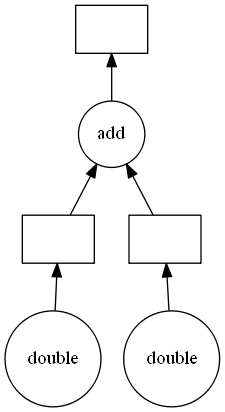

In [169]:
s.visualize()

In [75]:
%%time

s.compute()

Wall time: 1.02 s


10

In [31]:
n = 6
data = range(n)
output = []

for x in data:
    d = double(x)
    output.append(d)

total = delayed(sum)(output) # неявное сложение Delayed в функции sum
total = total + double(10)

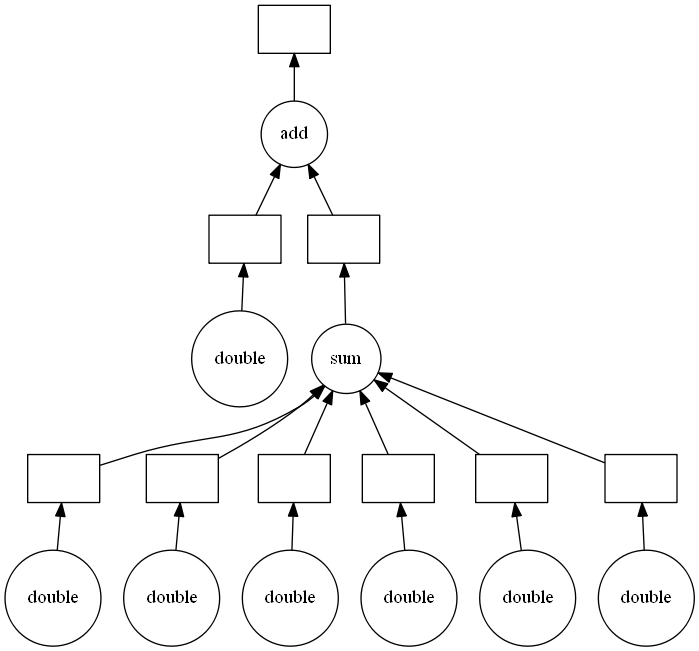

In [172]:
total.visualize()

Объекты Delayed __НЕ поддерживают__ следующие операции:

* Операции изменяющие значение объекта Delayed, такие как: `a += 1`
* Операции изменяющие значение объекта Delayed, такие как: `__setitem__/__setattr__ (a[0] = 1, a.foo = 1)`
* Итерацию по объекту Delayed: `for i in a: ...`
* Использование объекта Delayed в условии ветвления: `if a: ...`

Два последних пункта означают, что объекты Delayed не могут использоваться для управления потоком вычислений (__не могут использоваться в качестве условия if и в качестве итерируемого объекта__). Эти ограничения связаны с тем, что граф зависимостей задач, построенный при помощи `dask.delayed`, не меняется во время выполнения вычисления. Использование Delayed в условном операторе или в качестве объекта для итерации потребовало бы динамического изменения графа в зависимости от фактических значений Delayed.

Ограничение на динамическое изменение графа зависимости задач сужает возможности распараллеливания с помощью `dask.delayed`, но во многих случаях эти ограничения не являются существенными. В случае, если создавать и удалять задачи в графе зависимостей задач во время исполнения вычислений необходимо, то для этого необходимо пользоваться интерфейсом `Dask.Futures` [http://docs.dask.org/en/latest/futures.html#]

При этом, объекты Delayed могут использоваться:
* __внутри тела цикла__ (см пример выше)
* __внутри тела условного оператора__ 

---
`dask.delayed` не позволяет итерироваться по коллекциям Delayed, но позволяет полноценно работать с результатами многозначных функций с фиксированной длиной возвращаемого значения. 

У декоратора `dask.delayed` есть необязательный параметр:

`nout:int`, optional - количество результатов, возвращаемых в результате вычислений объекта отложенных вычислений Delayed. Если параметр установлен, то может быть произведена итерация по объектам в количестве nout единиц, доступна распаковка результатов. По умолчанию итерация по Delayed недоступна. Нужно иметь в виду, что nout=1, означает, что будет возвращен кортеж длиной в 1 элемент, а nout=0, что будет возвращен пустой кортеж.

In [32]:
@delayed(nout = 4)
def get_quaters(lst):
    l = len(lst)
    h = l//2
    q, q2 = h//2, (l-h)//2
    return lst[:q], lst[q:h], lst[h:h+q2], lst[h+q2:]

In [33]:
l1 = list(range(16))

In [34]:
ql = []
for q in get_quaters(l1):
    ql.append(delayed(sum)(q))
s = delayed(sum)(ql)

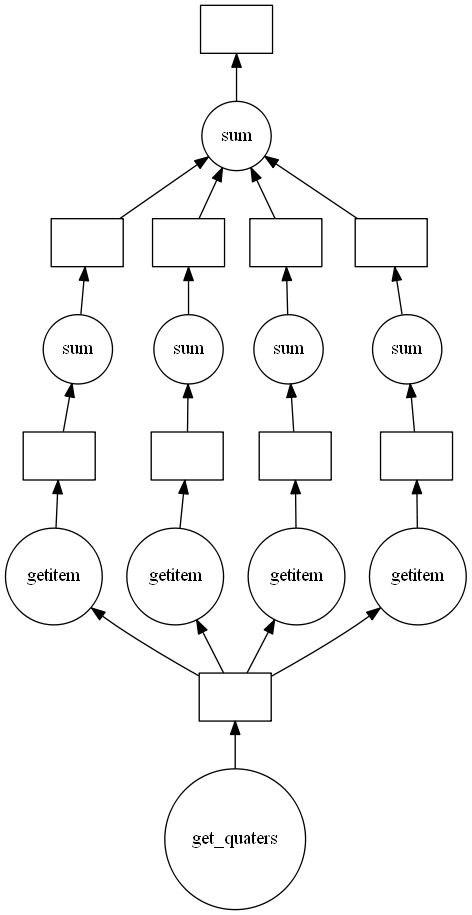

In [175]:
s.visualize()

In [35]:
s.compute()

120

In [36]:
q1, q2, q3, q4 = get_quaters(l1)
m = delayed(max)(q3)

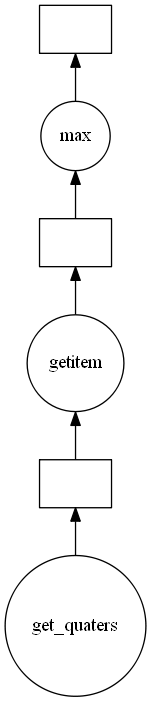

In [178]:
m.visualize()

## Эффективное распараллеливание алгоритмов

__*Повтор:*__

Распараллеливание алгоритмов сложная задача не имеющая универсального решения. Существует нексколько стратегий, которые успешно применяются во многих конкретных задачах. 

Для эффективного использования `dask.delayed` для распараллеливания вычислений существует важное техническое требование: каждый вызов `compute()` должен делатся для большого объема вычислений после их оформления в виде большого (но не слишком большого) количества вызовов `dask.delayed`. После того как будет создан обширный граф зависимостей задач метод `compute()` запускает планировщик, который сможет праллельно задействовать доступные вычислительные ресурсы.

При необходимости допустимо запускать `compute()` в середине процесса вычислений (например, когда без расчета конкретных результатов невозможно определить дальнейший ход вычислений), но нужно иметь ввиду, что для выполнения следующих шагов нужно будет ожидать, пока запущенные `compute()` вычисления не вернут результат.

__Эффективная грануляция вычислений: разбиение вычислений на множество фрагментов__

Каждый вызов `dask.delayed` с точки зрения Dask является одной операцией: Dask не пытается распараллелить вычисления находящиеся в рамках одного вызова `dask.delayed`. Т.е. для достижения параллелизма нужно большое количество вызовов `dask.delayed`: количество вызовов существенно большее чем количество исполнителей (worker) позволит не только найти параллельные задачи но и успешно компенсировать неоднородность объема вычислений при выполнении различных вызов `dask.delayed`.

_Пример 1: конвейрное распараллеливание_

In [155]:
# @delayed # конвейрное распараллеливание
def load(filename):
    data = [] # data from file
    return data

# @delayed # конвейрное распараллеливание
def process(data):
    prc_data = [] # processed data from data
    return prc_data

# @delayed # конвейрное распараллеливание
def aggregate(data):
    agr = '' # aggregated data


def f(filenames):
    results = []
    # выделить обработку файла в функцию для параллизма по данным:
    for filename in filenames: 
        data = load(filename)
        data = process(data)
        results.append(aggregate(data))
    return results

_Пример 2: распараллеливание по данным_

In [ ]:
# @delayed # распараллеливание по данным
def f_fl(filename):
    data = load(filename)
    data = process(data)
    return aggregate(data)
    
def f(filenames):
    results = []
    for filename in filenames: 
        results.append(f_fl(filename))
    return results

Эффективная грануляция вычислений: разбиение вычислений на фрагменты адекватного размера

Обработка каждой задачи `dask.delayed` занимает несколько сот микросекунд. Это не является проблемой, пока длительность вычислений не выполняемых в рамках вызова не становится сравнимой с накладными расходами. В таком случае имеет смысл группировать расчеты в пакеты, для этого могут подойти коллекции встроенные в Dask.

In [52]:
# очень простая (и быстрая) функция:
def f(a):
    return a + 1

In [160]:
# НЕверная организация вычислений:
results = []
for x in range(1000):  # Too many dask.delayed calls
    y = dask.delayed(f)(x)
    results.append(y)

In [ ]:
# Use collections

import dask.bag as db
b = db.from_sequence(1000000000, npartitions=1000)
b = b.map(f)

In [ ]:
# Or batch manually

def batch(seq):
    sub_results = []
    for x in seq:
        sub_results.append(f(x))
    return sub_results

batches = []
for i in range(0, 1000000000, 1000000):  # in steps of 1000000
    result_batch = dask.delayed(batch)(range(i, i + 1000000))
    batches.append(result_batch)

Для достижения нужного уровня грануляции необходимо найти хорошие места для разбиения вычислений на блоки. Для этого необходимо изучение не только алгоритма подлежащего распараллеливанию, но данных, которые планируется обрабатывать с его помощью.

---

При разбиении алгоритма на параллельно выполняемые операции с помощью `dask.delayed` обчно не требуется помещать вызов `dask.delayed` внутрь функции, обернутой в `dask.delayed`.

In [ ]:
# НЕверная организация вычислений:
@delayed
def process_all(L):
    result = []
    for x in L:
        y = dask.delayed(f)(x)
        result.append(y)
    return result

Поскольку функция `process_all` только обрабатывает объекты отложенных вычислений она выполняется быстро и нет необходимости оборачивать ее в `dask.delayed`.

In [161]:
# правильная организация вычислений:
def process_all(L):
    result = []
    for x in L:
        y = dask.delayed(f)(x)
        result.append(y)
    return result

## Коллекции Dask и вычисления организованные с помощью `dask.delayed`

Когда вы помещаете Dask Array или Dask DataFrame в отложенный вызов (delayed), эта функция получит эквивалент NumPy или Pandas. Помните, что если ваш массив большой, это может привести к сбою обработчиков.

Вместо этого чаще используются такие методы, как da.map_blocks или df.map_partitions, или для превращения ваших Array или DataFrame во множество отложенных объектов.

In [ ]:
import dask.dataframe as dd

In [ ]:
df = dd.read_csv('/path/to/*.csv')
# Опасно: df будет расчитан перед передачей в train!
dask.delayed(train)(df)  # might as well have used Pandas instead

In [ ]:
# Однако, если вы готовы превратить ваш массив Dask / DataFrame в единый блок, тогда это нормально:
dask.delayed(train)(..., y=df.sum())

In [ ]:
import dask.dataframe as dd
df = dd.read_csv('/path/to/*.csv')

df.map_partitions(train)


Часто нужно выполнить небольшую специальную обработку с помощью dask.delayed (например, для сложной загурзки данных), затем использовать алгоритмы dask.array или dask.dataframe, а затем вернуться к ручной работе с dask.delayed . С этой целью все коллекции Dask поддерживают функции `from_delayed` и методы `to_delayed`.

In [ ]:
partitions = df.to_delayed()

delayed_values = [dask.delayed(train)(part) for part in partitions]

В качестве примера рассмотрим случай, когда мы храним табличные данные в специализированном формате, неизвестном Dask DataFrame. Этот формат естественным образом разбит на части (файлы), и у нас есть функция, которая считывает один фрагмент в Pandas DataFrame. Мы используем dask.delayed для ленивого чтения этих файлов в Pandas DataFrames, используем dd.from_delayed для объединения этих частей в один Dask DataFrame, используем сложные алгоритмы внутри DataFrame (groupby, join и т. Д.), А затем переключаемся обратно на dask.delayed, чтобы сохранить наши результаты обратно в пользовательский формат:

In [ ]:
import dask.dataframe as dd
from dask.delayed import delayed

from my_custom_library import load, save

filenames = ...
dfs = [delayed(load)(fln) for fln in filenames]

df = dd.from_delayed(dfs)
df = ... # do work with dask.dataframe

dfs = df.to_delayed()
writes = [delayed(save)(df, fn) for df, fn in zip(dfs, filenames)]

dd.compute(*writes)

Обработка данных часто бывает сложной задачей, и dask.delayed предоставляет пользователям возможность самостоятельно справиться с этой сложностью и решить проблему последней мили для нестандартных форматов и сложных ситуаций.